# Model Training

## 0. Setup

In [1]:
# Automatic reloading
%load_ext autoreload
%autoreload 2

In [2]:
####################
# Required Modules #
####################

# Generic/Built-in
import random
import sys 
import os

# Libs
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

The cell below sets up the environment by adding the project’s root directory to the system path and changing the current working directory, enabling imports from the `/src` folder. **This cell should only be ran once per session.**

In [3]:
# Get the project directory 
current_dir = os.path.abspath('') # Current '\notebooks' directory
project_dir = os.path.abspath(os.path.join(current_dir, '..')) # Move up one level to project root directory

# Add the project directory to sys.path
sys.path.append(project_dir)

# Move up to project directory
os.chdir(project_dir)
os.getcwd()

'c:\\Users\\Ryan Lee\\Desktop\\50.038 Computational Data Science\\Digital-Asset-Prediction'

In [4]:
# Import custom modules
from src.dataset import *
from src.models import *
from src.train_eval import *
from src.utils import *

c:\Users\Ryan Lee\.conda\envs\term6\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Seeding
SEED = 42

# To be safe, seed all modules for full reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using CUDA
np.random.seed(SEED)
random.seed(SEED)

In [6]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1. Prepare Dataset

In [7]:
# File paths
TRAIN_PATH = "data/processed/train_set.csv"
VAL_PATH = "data/processed/val_set.csv"
TEST_PATH = "data/processed/test_set.csv"

# Hyperparameters
INPUT_SEQUENCE_LENGTH = 14 # Number of timesteps (days) in input sequence
DATASET_STRIDE = 1
BATCH_SIZE = 256

In [8]:
# Create Dataset objects
train_dataset = CryptoDataset(
    csv_file=TRAIN_PATH,
    seq_length=INPUT_SEQUENCE_LENGTH,
    stride=DATASET_STRIDE
)
val_dataset = CryptoDataset(
    csv_file=VAL_PATH,
    seq_length=INPUT_SEQUENCE_LENGTH,
    stride=DATASET_STRIDE
)
test_dataset = CryptoDataset(
    csv_file=TEST_PATH,
    seq_length=INPUT_SEQUENCE_LENGTH,
    stride=DATASET_STRIDE
)

print("Total number of samples (sequences)")
print("Training:", len(train_dataset))
print("Validation:", len(val_dataset))
print("Test:", len(test_dataset))

Total number of samples (sequences)
Training: 77790
Validation: 16900
Test: 10000


In [9]:
# Create respective data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## 2. Training
`train_model` will save model parameters to `saved_models` directory (by default).

In [10]:
# Hyperparameters
LEARNING_RATE = 0.001 # standard for Adam
NUM_EPOCHS = 25 
SAVE_INTERVAL = 5
WEIGHT_DECAY = 1e-5 # L2 Regularization Coefficient

In [11]:
# Create model
model_kwargs = {} # Empty dict means default hyperparameters
model = CryptoInformer(**model_kwargs)
print(model)

CryptoInformer(
  (embedding): Linear(in_features=11, out_features=64, bias=True)
  (positional_encoder): SinusoidalPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (attn): ProbAttention(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (attention): AttentionLayer(
        (inner_attention): ProbAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (query_projection): Linear(in_features=64, out_features=64, bias=True)
        (key_projection): Linear(in_features=64, out_features=64, bias=True)
        (value_projection): Linear(in_features=64, out_features=64, bias=True)
        (out_projection): Linear(in_features=64, out_features=64, bias=True)
      )
      (conv1): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,)

In [12]:
# Training optimizer
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

In [13]:
# Optional: Load previously trained model parameters (.pth file)
pretrained_model_path = "saved_models/<sub-directory>/<model-path>.pth"
# model.load_state_dict(torch.load(pretrained_model_path))

In [ ]:
training_loss_history, validation_loss_history, mae_history, r2_history, explained_var_history, normalizer = train_model(
    model, optimizer, train_loader, val_loader,
    num_epochs=NUM_EPOCHS, save_interval=SAVE_INTERVAL,
    device=device
)

Model moved to cuda
(1) Creating subdirectory (saved_models\CryptoInformer_2025-04-20_20-50-10) for saving model params...
(2) Computing normalization statistics from the training dataset...
(3) Beginning training loop (25 epochs)...
Epoch [1/25] | Time: 58.20s
(Training) Loss: 13738169.6242
(Validation) Loss: 44872024.1291, MAE: 794.9830, R2: -0.0029, Explained Variance: 0.0101
✅ Model saved: saved_models\CryptoInformer_2025-04-20_20-50-10\Best_R2.pth
Epoch [2/25] | Time: 45.97s
(Training) Loss: 12911156.6424
(Validation) Loss: 42316913.7217, MAE: 708.8717, R2: 0.0542, Explained Variance: 0.0650
✅ Model saved: saved_models\CryptoInformer_2025-04-20_20-50-10\Best_R2.pth
Epoch [3/25] | Time: 45.19s
(Training) Loss: 10881163.0523
(Validation) Loss: 37323644.5775, MAE: 633.5633, R2: 0.1658, Explained Variance: 0.1739
✅ Model saved: saved_models\CryptoInformer_2025-04-20_20-50-10\Best_R2.pth
Epoch [4/25] | Time: 45.09s
(Training) Loss: 8125302.9256
(Validation) Loss: 30871130.9663, MAE: 59

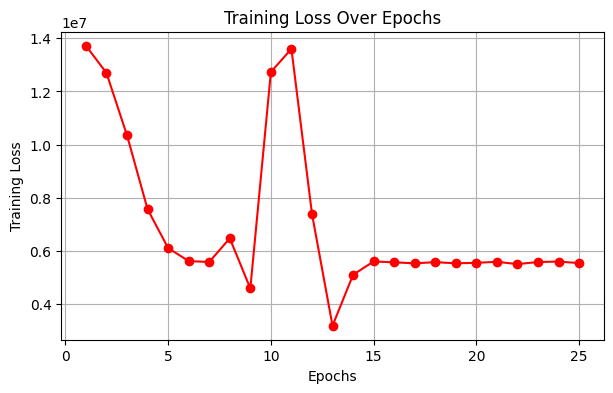

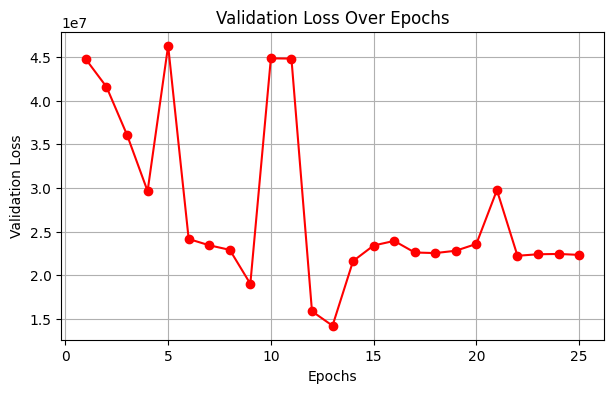

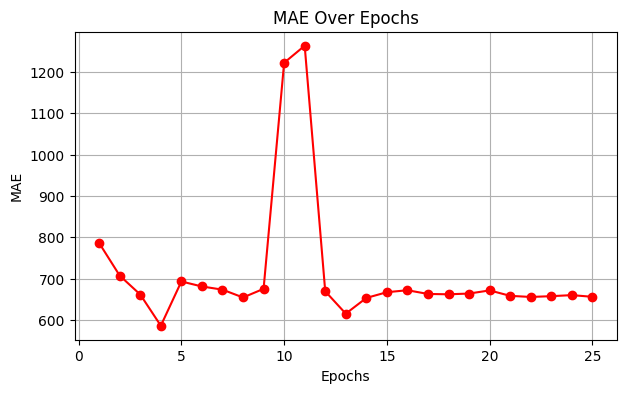

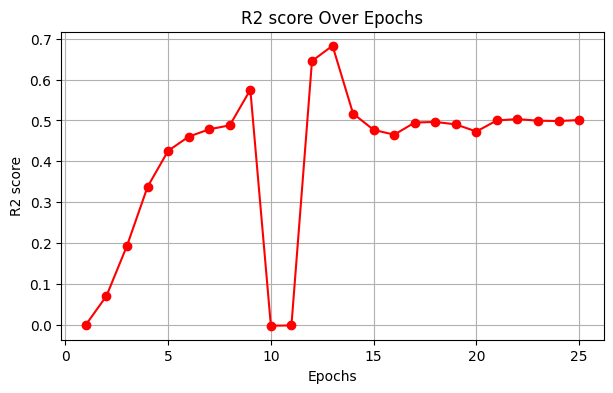

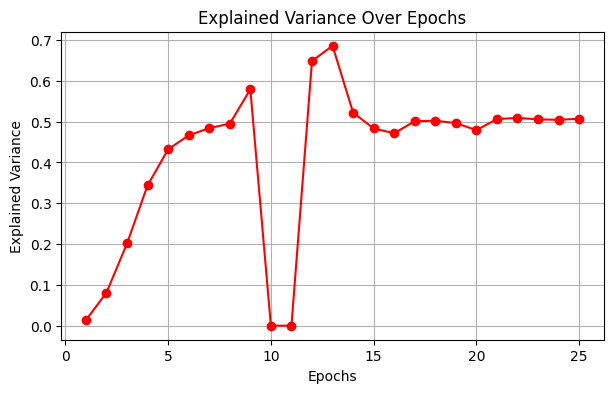

✅ Plots saved to: results\CryptoInformer_2025-04-20_20-47-51
✅ Metric histories saved to: results\CryptoInformer_2025-04-20_20-47-51\metric_histories.pth


In [ ]:
save_dir = save_training_plots_and_metric_history(
    training_loss_history, validation_loss_history, mae_history, r2_history, explained_var_history, type(model).__name__
)

## 3. Test

In [ ]:
final_evaluation_loss, final_mae, final_r2, final_explained_var = evaluate_crypto_model(model, test_loader, normalizer)
print(f"Loss: {final_evaluation_loss:.4f}, MAE: {final_mae:.4f}, R2: {final_r2:.4f}, Explained Variance: {final_explained_var:.4f}")

Loss: 54619118.2687, MAE: 959.1930, R2: 0.3769, Explained Variance: 0.3830


In [ ]:
save_training_session_information(
    save_dir=save_dir,
    # Dataset Config
    sequence_size=INPUT_SEQUENCE_LENGTH,
    stride=DATASET_STRIDE,
    random_state=SEED,
    # Training Hyperparams
    optimizer_name=type(optimizer).__name__,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    # Model Hyperparams
    model_kwargs=model_kwargs,
    # Test Results (on model params from final epoch)
    test_loss=final_evaluation_loss,
    test_mae=final_mae,
    test_r2=final_r2,
    test_explained_var=final_explained_var
)

✅ Saved training session information to results\CryptoInformer_2025-04-20_20-47-51\model_info.txt
